<a href="https://colab.research.google.com/github/rajy4683/S15Test/blob/master/S15Unet_Expand_UpScale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!nvidia-smi

Tue May 19 05:37:53 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import sys

Mounted at /content/drive


In [0]:
sys.path.append('/content/drive/My Drive/EVA4/RekogNizer')
sys.path.append('/content/drive/My Drive/EVA4')
sys.path.append('/content/drive/My Drive/EVA4/DenseDepth')

### Dependencies


In [6]:
!pip install -r /content/drive/My\ Drive/EVA4/RekogNizer/requirements.txt

     |████████████████████████████████| 112kB 2.8MB/s 
     |████████████████████████████████| 1.4MB 8.7MB/s 
     |████████████████████████████████| 163kB 16.3MB/s 
     |████████████████████████████████| 102kB 8.9MB/s 
     |████████████████████████████████| 112kB 16.7MB/s 
     |████████████████████████████████| 102kB 8.7MB/s 
     |████████████████████████████████| 460kB 15.8MB/s 
     |████████████████████████████████| 634kB 22.3MB/s 
     |████████████████████████████████| 71kB 9.0MB/s 
     |████████████████████████████████| 71kB 9.0MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-none-any.whl size=6489 sha256=08880ab5f031664028222c7e82d25cd0a47b308a31f7d308fe68195a8c9db18f
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for gql: filename=gql-0.2.0-cp36-none-any.whl size=7630 sha256=5edf75adedf63d14c17e01880f69a2189ebecd643f439d17ccc6cb33f2fb4f32
  Stored in directory: /root/.cache

In [7]:
!pip install -U git+https://github.com/albu/albumentations

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-j8mqb7a_
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-j8mqb7a_
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=65055 sha256=85a476ad4235de76df37d80ec131aad0e75a0cdbc6a50da63a98a035c89ac1ac
  Stored in directory: /tmp/pip-ephem-wheel-cache-fkdttks8/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [8]:
!wandb login a6f947d2d2f69e7a8c8ca0f69811fd554f27d204


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


In [0]:
import os

import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.color import label2rgb

import albumentations as A
import random
from google.colab.patches import cv2_imshow
from PIL import Image
import glob
import pandas as pd

import torch
from zipfile import ZipFile
import re
import h5py
import time



In [10]:
%load_ext autoreload
%autoreload 2
import torch
import torchvision
import torchvision.transforms as transforms
from RekogNizer import hyperparams


from albumentations import Compose, RandomCrop, Normalize, HorizontalFlip, Resize, Cutout, MotionBlur
from albumentations import (
    HorizontalFlip, Compose, RandomCrop, Cutout,Normalize, HorizontalFlip, RandomBrightnessContrast,
    Resize,RandomSizedCrop, MotionBlur,MultiplicativeNoise,InvertImg, IAAFliplr,
	IAAPerspective,
)
from albumentations.pytorch import ToTensor
import random

from torchvision.datasets.vision import VisionDataset
from torchvision.datasets.utils import check_integrity, download_and_extract_archive
import os
import sys
import numpy as np
from torchvision import datasets
#from RekogNizer import imgnetloader
from RekogNizer import basemodelclass
from RekogNizer import mmdlrfinder

from RekogNizer import mmdtraintest
from RekogNizer import mmddataloader
from RekogNizer import mmdlosses
from RekogNizer import mmdmodels

from RekogNizer import hyperparams
from RekogNizer import fileutils

from torch.utils.data import Dataset
import shutil
from tqdm import tqdm
from RekogNizer import mmdmodels

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, OneCycleLR, MultiStepLR, CyclicLR, ReduceLROnPlateau


import kornia

import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
import wandb

  pip install torch-lr-finder -v --global-option="amp"
  pip install torch-lr-finder -v --global-option="amp"


## Mask Image (Mean and Variance
Mask Mean:0.057950844077600344, Mask StdDev:0.0016620444341229432
### Depth mean and Variance
Depth Mean:0.3679109312239146, Depth StdDev:0.03551773442719045

In [0]:
!rm -rf /content/train && mkdir -p /content/train
!rm -rf /content/test && mkdir -p /content/test

In [12]:
csv_file ='/content/drive/My Drive/EVA4/tsai/S15EVA4/FinalDataSet/DepthMapDataSetTrain.csv'
root_dir = '/content/drive/My Drive/EVA4/tsai/S15EVA4/'
batch_start = 90000
batch_end = batch_start+30000
dest_dir="/content/train"

mmddataloader.extract_data_files_mt(csv_file, root_dir, batch_start,batch_end, dest_dir=dest_dir)


Extracting image and mask files Total:9
Zip Name:image_mask_gt1k2k.zip Total Files:10076
Zip Name:depth_mask_gt_1k2k.zip Total Files:5038
Zip Name:image_mask_gt6k8k.zip Total Files:9838
Zip Name:image_mask_gt2k6k.zip Total Files:19458
Zip Name:image_mask_gt8k12k.zip Total Files:20630
Zip Name:depth_mask_gt_2k6k.zip Total Files:9729
Zip Name:depth_mask_gt_6k8k.zip Total Files:4919
Zip Name:depth_mask_gt_8k12k.zip Total Files:10315
Extracting bg files
Total file count:90113 


In [0]:
size_hw = (224,224)
dest_dir="/content/train"
train_batch_size = 64
depth_dataset = mmddataloader.DepthMaskDataSet(csv_file, dest_dir, batch_start,batch_end, read_zip=False,
                                 transform_base=mmddataloader.resize_bg(size_hw[0],size_hw[1],[0.56632738, 0.51567622, 0.45670792], [0.1076622, 0.10650349, 0.12808967] ),
                                 transform_bg=mmddataloader.resize_bg(size_hw[0],size_hw[1],[0.57469445, 0.52241555, 0.45992244], [0.11322354, 0.11195428, 0.13441683]),
                                 transform_mask = mmddataloader.resize_bg_nonNorm(size_hw[0],size_hw[1]),
                                 transform_depth = mmddataloader.resize_bg_nonNorm(size_hw[0],size_hw[1]),
                                 #transform_mask=mmddataloader.resize_bg(size_hw[0],size_hw[1], [0.0579508], [0.001662]),
                                 #transform_depth=mmddataloader.resize_bg(size_hw[0],size_hw[1], [0.3679109], [0.03551773]),
                                 )
from torch.utils.data import DataLoader
kwargs= { 'num_workers':8,'pin_memory': True}
train_loader = DataLoader(depth_dataset, batch_size=train_batch_size, shuffle=False, **kwargs)

In [16]:
test_csv_file ='/content/drive/My Drive/EVA4/tsai/S15EVA4/FinalDataSet/DepthMapDataSetTest.csv'
root_dir = '/content/drive/My Drive/EVA4/tsai/S15EVA4/'
test_batch_start = 0
test_batch_end = test_batch_start + 512
test_dest_dir = "/content/test"

mmddataloader.extract_data_files(test_csv_file, root_dir, test_batch_start,test_batch_end, dest_dir=test_dest_dir)

Extracting image and mask files


image_mask_gt1k2k.zip: 100%|██████████| 1026/1026 [00:25<00:00, 39.57it/s]


Extracting depth files


depth_mask_gt_1k2k.zip: 100%|██████████| 513/513 [00:42<00:00, 12.10it/s]

Extracting bg files
Total file count:1556 


In [0]:
iter(train_loader).next()['input'].shape

torch.Size([101, 6, 56, 56])

In [0]:
size_hw = (224,224)
test_dest_dir = "/content/test"
test_batch_size=8
test_dataset = mmddataloader.DepthMaskDataSet(test_csv_file, test_dest_dir, test_batch_start,test_batch_end,read_zip=False,
                                 transform_base=mmddataloader.resize_bg(size_hw[0],size_hw[1],[0.56632738, 0.51567622, 0.45670792], [0.1076622, 0.10650349, 0.12808967] ),
                                 transform_bg=mmddataloader.resize_bg(size_hw[0],size_hw[1],[0.57469445, 0.52241555, 0.45992244], [0.11322354, 0.11195428, 0.13441683]),
                                 transform_mask = mmddataloader.resize_bg_nonNorm(size_hw[0],size_hw[1]),
                                 transform_depth = mmddataloader.resize_bg_nonNorm(size_hw[0],size_hw[1]),
                                 #transform_mask=mmddataloader.resize_bg(size_hw[0],size_hw[1], [0.0579508], [0.001662]),
                                 #transform_depth=mmddataloader.resize_bg(size_hw[0],size_hw[1], [0.3679109], [0.03551773]),
                                 )
from torch.utils.data import DataLoader
kwargs= { 'num_workers':4,'pin_memory': True}
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, **kwargs)

In [0]:
size_hw = (224,224)
dest_dir="/content/train"
train_batch_size = 8
depth_dataset = mmddataloader.DepthMaskDataSet(csv_file, dest_dir, batch_start,batch_end, read_zip=False,
                                 transform_base=mmddataloader.resize_bg(size_hw[0],size_hw[1],[0.56632738, 0.51567622, 0.45670792], [0.1076622, 0.10650349, 0.12808967] ),
                                 transform_bg=mmddataloader.resize_bg(size_hw[0],size_hw[1],[0.57469445, 0.52241555, 0.45992244], [0.11322354, 0.11195428, 0.13441683]),
                                 transform_mask = mmddataloader.resize_bg_nonNorm(size_hw[0],size_hw[1]),
                                 transform_depth = mmddataloader.resize_bg_nonNorm(size_hw[0],size_hw[1]),
                                 #transform_mask=mmddataloader.resize_bg(size_hw[0],size_hw[1], [0.0579508], [0.001662]),
                                 #transform_depth=mmddataloader.resize_bg(size_hw[0],size_hw[1], [0.3679109], [0.03551773]),
                                 )
from torch.utils.data import DataLoader
kwargs= { 'num_workers':4,'pin_memory': True}
train_loader = DataLoader(depth_dataset, batch_size=train_batch_size, shuffle=False, **kwargs)

In [0]:
from RekogNizer import mmdtraintest
from RekogNizer import mmdlosses

criterion={"mask":[mmdlosses.LocalBCELoss, mmdlosses.LocalSSIMLoss ], 
           "depth":[mmdlosses.LocalL1Loss, mmdlosses.LocalSSIMLoss]}

#criterion={"mask":[mmdlosses.dice_loss, mmdlosses.LocalBCELoss, mmdlosses.LocalSSIMLoss ], "depth":[mmdlosses.LocalRMSELoss]}
#model = basemodelclass.MonoMaskDepthResNetFunc()
optimizer=optim.SGD(model_new.parameters(), lr=0.001,momentum=0.9,  weight_decay=0)
lrfinder = mmdtraintest.find_lr_type1(model_new, optimizer, criterion, train_loader, testloader=None, seed=1, start_lr=0.0001, end_lr=1, step_mode="exp",num_iter=100)



Learning rate search finished. See the graph with {finder_name}.plot()


0.02754228703338166 1.0 0.8153246641159058
{'lr': [0.00010964781961431851, 0.0001202264434617413, 0.0001318256738556407, 0.00014454397707459274, 0.00015848931924611136, 0.00017378008287493755, 0.00019054607179632473, 0.00020892961308540398, 0.00022908676527677731, 0.000251188643150958, 0.0002754228703338166, 0.00030199517204020164, 0.00033113112148259116, 0.0003630780547701014, 0.00039810717055349724, 0.00043651583224016605, 0.00047863009232263843, 0.0005248074602497726, 0.000575439937337157, 0.0006309573444801934, 0.0006918309709189364, 0.0007585775750291837, 0.0008317637711026711, 0.0009120108393559097, 0.001, 0.0010964781961431851, 0.0012022644346174132, 0.0013182567385564075, 0.0014454397707459273, 0.0015848931924611134, 0.0017378008287493754, 0.0019054607179632473, 0.00208929613085404, 0.0022908676527677737, 0.0025118864315095794, 0.0027542287033381664, 0.003019951720402016, 0.0033113112148259113, 0.0036307805477010144, 0.003981071705534973, 0.004365158322401658, 0.004786300923226

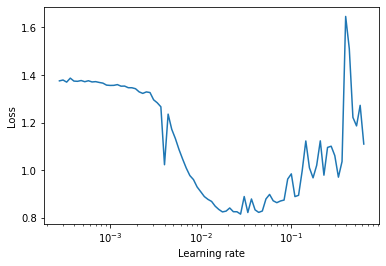

In [0]:
min_lr = lrfinder.history['lr'][np.argmin(lrfinder.history['loss'])]
max_lr = np.max(lrfinder.history['lr'])
print(min_lr, max_lr, np.min(lrfinder.history['loss']))
print(lrfinder.history)
lrfinder.plot()

In [0]:
summary(model_new, input_size=(6,64,64)  )

In [0]:
del model
torch.cuda.empty_cache()

In [0]:
lrfinder.reset()

In [0]:
device = torch.device("cuda" if not hyperparams.hyperparameter_defaults['no_cuda'] else "cpu")
model_new  =mmdmodels.UNet(n_channels=6, n_classes=2)
expand_model  =mmdmodels.CustomUNet(model_new,n_channels=6, n_classes=2)
# model_new = mmdtraintest.load_model_for_infer(model_new, 
#                                   '/content/drive/My Drive/EVA4/model_saves/model-30d31a02c7.h5',
#                                   device)

In [0]:
expand_model  =mmdmodels.CustomUNet(model_new,n_channels=6, n_classes=2)

#summary(expand_model.to(device),input_size=(6,224,224))

In [0]:
for parameter in model_new.parameters():
    print(parameter.requires_grad)# = False

In [0]:
expand_model.named_parameters()

In [0]:
model_new_params = ['baseUNet.'+param[0] for param in list(model_new.named_parameters()) ]
expand_model_params = [  ]
for param in list(expand_model.named_parameters()):
    if re.search('up',param[0]) or (param[0] not in model_new_params):
        expand_model_params.append(param[1])
    

In [0]:
len(expand_model_params)

51

In [0]:
len(model_new_params),len(expand_model_params), len(list(expand_model.parameters()))

(74, 19, 93)

In [0]:
len(expand_model_params)

19

In [72]:
######## OCP 
from RekogNizer import mmdmodels
device = torch.device("cuda" if not hyperparams.hyperparameter_defaults['no_cuda'] else "cpu")
tqdm._instances.clear()
hyperparams.set_hyperparam({"epochs":10})

hyperparams.hyperparameter_defaults['run_name'] = fileutils.rand_run_name()
hyperparams.hyperparameter_defaults['epochs'] = 20
hyperparams.hyperparameter_defaults['lr'] = 0.1

print("Initializing datasets and dataloaders")    

#model_new =  mmdmodels.UNet(n_channels=6, n_classes=2)
wandb_run_init = wandb.init(config=hyperparams.hyperparameter_defaults, 
                            project=hyperparams.hyperparameter_defaults['project'])
#wandb.watch_called = False
config = wandb.config
print(config)
#wandb.watch(model_new, log="none")

# optimizer=optim.SGD(model_new.parameters(), lr=config.lr,momentum=config.momentum,
#                         weight_decay=0)
optimizer=optim.SGD(expand_model_params, lr=config.lr,momentum=config.momentum,
                        weight_decay=1e-5)
#expand_model_params
# criterion={"mask":[mmdlosses.dice_loss, mmdlosses.LocalBCELoss, mmdlosses.LocalPixelLoss], 
#            "depth":[mmdlosses.LocalRMSELoss, mmdlosses.LocalSSIMLoss]}

criterion={"mask":[mmdlosses.dice_loss, mmdlosses.LocalL1Loss,], 
           "depth":[mmdlosses.LocalRMSELoss, mmdlosses.LocalSSIMLoss]}

#scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True, threshold=0.0001)
scheduler = OneCycleLR(optimizer, 
                        config.ocp_max_lr, 
                        epochs=config.epochs, 
                        cycle_momentum=True, 
                        steps_per_epoch=len(train_loader), 
                        base_momentum=config.momentum,
                        max_momentum=0.95, 
                        pct_start=0.208,
                        anneal_strategy=config.anneal_strategy,
                        div_factor=config.div_factor,
                        final_div_factor=config.final_div_factor
                           )

final_model_path = mmdtraintest.execute_model(expand_model, 
            hyperparams.hyperparameter_defaults, 
            train_loader, test_loader, 
            device, 
            wandb=wandb,
            optimizer_in=optimizer,
            scheduler=scheduler,
            prev_saved_model=None,
            criterion=criterion,
            save_best=True,
            lars_mode=False,
            batch_step=True)

Initializing datasets and dataloaders


  0%|          | 0/469 [00:00<?, ?it/s]

wandb_version: 1

_wandb:
  desc: null
  value:
    cli_version: 0.8.36
    framework: torch
    is_jupyter_run: true
    is_kaggle_kernel: false
    python_version: 3.6.9
anneal_strategy:
  desc: null
  value: linear
batch_size:
  desc: null
  value: 512
bias:
  desc: null
  value: false
cycle_momentum:
  desc: null
  value: false
div_factor:
  desc: null
  value: 128
dropout:
  desc: null
  value: 0.1
epochs:
  desc: null
  value: 20
factor:
  desc: null
  value: 0.0
final_div_factor:
  desc: null
  value: 64
lr:
  desc: null
  value: 0.1
lr_decay_threshold:
  desc: null
  value: 0.0
lr_policy:
  desc: null
  value: ocp
momentum:
  desc: null
  value: 0.9
no_cuda:
  desc: null
  value: false
ocp_max_lr:
  desc: null
  value: 0.5
pct_start:
  desc: null
  value: 0.208
project:
  desc: null
  value: news5
run_name:
  desc: null
  value: 26e37b2200
sched_lr_gamma:
  desc: null
  value: 0.5
sched_lr_step:
  desc: null
  value: 1
seed:
  desc: null
  value: 1
split_pct:
  desc: null
  val

loss=0.917706 m_loss=0.862970 d_loss=0.054736 batch_id=468: 100%|██████████| 469/469 [04:59<00:00,  1.57it/s]
loss=0.9671630263328552 batch_id=64: 100%|██████████| 65/65 [00:05<00:00, 11.71it/s]



Epoch: 1 Train set: Average loss: 0.014522, Mask loss:0.000865, Depth loss:0.013656, lr:0
Epoch: 1 Test set: Average loss: 0.119461, Mask loss:0.110788, Depth loss:0.008673
Model saved as Test loss reduced from  10000.0  to  0.1194612507002163


loss=0.915600 m_loss=0.862544 d_loss=0.053056 batch_id=468: 100%|██████████| 469/469 [04:58<00:00,  1.57it/s]
loss=0.9660218358039856 batch_id=64: 100%|██████████| 65/65 [00:05<00:00, 11.65it/s]



Epoch: 2 Train set: Average loss: 0.014482, Mask loss:0.000833, Depth loss:0.013649, lr:0
Epoch: 2 Test set: Average loss: 0.119415, Mask loss:0.110770, Depth loss:0.008646
Model saved as Test loss reduced from  0.1194612507002163  to  0.11941541949210809


loss=0.914067 m_loss=0.862264 d_loss=0.051802 batch_id=468: 100%|██████████| 469/469 [04:58<00:00,  1.57it/s]
loss=0.9651215076446533 batch_id=64: 100%|██████████| 65/65 [00:05<00:00, 11.88it/s]



Epoch: 3 Train set: Average loss: 0.014461, Mask loss:0.000815, Depth loss:0.013646, lr:0
Epoch: 3 Test set: Average loss: 0.119395, Mask loss:0.110763, Depth loss:0.008632
Model saved as Test loss reduced from  0.11941541949210809  to  0.1193954765680473


loss=0.912804 m_loss=0.861981 d_loss=0.050822 batch_id=468: 100%|██████████| 469/469 [04:57<00:00,  1.58it/s]
loss=0.9643931984901428 batch_id=64: 100%|██████████| 65/65 [00:05<00:00, 11.65it/s]



Epoch: 4 Train set: Average loss: 0.014444, Mask loss:0.000801, Depth loss:0.013643, lr:0
Epoch: 4 Test set: Average loss: 0.119384, Mask loss:0.110757, Depth loss:0.008627
Model saved as Test loss reduced from  0.1193954765680473  to  0.11938422383853102


loss=0.911898 m_loss=0.861922 d_loss=0.049976 batch_id=468: 100%|██████████| 469/469 [04:58<00:00,  1.57it/s]
loss=0.9636750221252441 batch_id=64: 100%|██████████| 65/65 [00:05<00:00, 11.89it/s]



Epoch: 5 Train set: Average loss: 0.014430, Mask loss:0.000789, Depth loss:0.013641, lr:0
Epoch: 5 Test set: Average loss: 0.119379, Mask loss:0.110753, Depth loss:0.008626
Model saved as Test loss reduced from  0.11938422383853102  to  0.11937884024941665


loss=0.910952 m_loss=0.861757 d_loss=0.049195 batch_id=468: 100%|██████████| 469/469 [04:58<00:00,  1.57it/s]
loss=0.9632330536842346 batch_id=64: 100%|██████████| 65/65 [00:05<00:00, 11.81it/s]



Epoch: 6 Train set: Average loss: 0.014417, Mask loss:0.000778, Depth loss:0.013640, lr:0
Epoch: 6 Test set: Average loss: 0.119371, Mask loss:0.110745, Depth loss:0.008626
Model saved as Test loss reduced from  0.11937884024941665  to  0.1193712297935932


loss=0.910268 m_loss=0.861754 d_loss=0.048514 batch_id=468: 100%|██████████| 469/469 [04:58<00:00,  1.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch: 7 Train set: Average loss: 0.014406, Mask loss:0.000768, Depth loss:0.013638, lr:0
Epoch: 7 Test set: Average loss: 0.119385, Mask loss:0.110756, Depth loss:0.008629


loss=0.909519 m_loss=0.861636 d_loss=0.047883 batch_id=468: 100%|██████████| 469/469 [04:57<00:00,  1.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch: 8 Train set: Average loss: 0.014396, Mask loss:0.000759, Depth loss:0.013637, lr:0
Epoch: 8 Test set: Average loss: 0.119385, Mask loss:0.110754, Depth loss:0.008632


loss=0.908787 m_loss=0.861469 d_loss=0.047319 batch_id=468: 100%|██████████| 469/469 [04:57<00:00,  1.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch: 9 Train set: Average loss: 0.014387, Mask loss:0.000751, Depth loss:0.013636, lr:0
Epoch: 9 Test set: Average loss: 0.119374, Mask loss:0.110740, Depth loss:0.008634


loss=0.908398 m_loss=0.861613 d_loss=0.046786 batch_id=468: 100%|██████████| 469/469 [04:57<00:00,  1.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch: 10 Train set: Average loss: 0.014378, Mask loss:0.000743, Depth loss:0.013635, lr:0
Epoch: 10 Test set: Average loss: 0.119378, Mask loss:0.110741, Depth loss:0.008637


loss=0.907622 m_loss=0.861334 d_loss=0.046288 batch_id=468: 100%|██████████| 469/469 [04:58<00:00,  1.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch: 11 Train set: Average loss: 0.014370, Mask loss:0.000736, Depth loss:0.013634, lr:0
Epoch: 11 Test set: Average loss: 0.119379, Mask loss:0.110739, Depth loss:0.008640


loss=0.907122 m_loss=0.861282 d_loss=0.045841 batch_id=468: 100%|██████████| 469/469 [04:57<00:00,  1.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch: 12 Train set: Average loss: 0.014362, Mask loss:0.000729, Depth loss:0.013633, lr:0
Epoch: 12 Test set: Average loss: 0.119383, Mask loss:0.110742, Depth loss:0.008642


loss=0.906605 m_loss=0.861197 d_loss=0.045408 batch_id=468: 100%|██████████| 469/469 [04:57<00:00,  1.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch: 13 Train set: Average loss: 0.014354, Mask loss:0.000723, Depth loss:0.013632, lr:0
Epoch: 13 Test set: Average loss: 0.119390, Mask loss:0.110744, Depth loss:0.008646


loss=0.906162 m_loss=0.861155 d_loss=0.045007 batch_id=468: 100%|██████████| 469/469 [04:57<00:00,  1.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch: 14 Train set: Average loss: 0.014347, Mask loss:0.000717, Depth loss:0.013631, lr:0
Epoch: 14 Test set: Average loss: 0.119388, Mask loss:0.110738, Depth loss:0.008650


loss=0.905707 m_loss=0.861090 d_loss=0.044617 batch_id=468: 100%|██████████| 469/469 [04:57<00:00,  1.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch: 15 Train set: Average loss: 0.014341, Mask loss:0.000711, Depth loss:0.013630, lr:0
Epoch: 15 Test set: Average loss: 0.119390, Mask loss:0.110737, Depth loss:0.008653


loss=0.905253 m_loss=0.861004 d_loss=0.044249 batch_id=468: 100%|██████████| 469/469 [04:56<00:00,  1.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch: 16 Train set: Average loss: 0.014335, Mask loss:0.000706, Depth loss:0.013629, lr:0
Epoch: 16 Test set: Average loss: 0.119395, Mask loss:0.110737, Depth loss:0.008659


loss=0.905042 m_loss=0.861148 d_loss=0.043894 batch_id=468: 100%|██████████| 469/469 [04:57<00:00,  1.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch: 17 Train set: Average loss: 0.014331, Mask loss:0.000701, Depth loss:0.013630, lr:0
Epoch: 17 Test set: Average loss: 0.119403, Mask loss:0.110743, Depth loss:0.008661


loss=0.904483 m_loss=0.860902 d_loss=0.043581 batch_id=468: 100%|██████████| 469/469 [04:57<00:00,  1.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch: 18 Train set: Average loss: 0.014324, Mask loss:0.000696, Depth loss:0.013628, lr:0
Epoch: 18 Test set: Average loss: 0.119403, Mask loss:0.110740, Depth loss:0.008663


loss=0.904118 m_loss=0.860839 d_loss=0.043279 batch_id=468: 100%|██████████| 469/469 [04:57<00:00,  1.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch: 19 Train set: Average loss: 0.014318, Mask loss:0.000691, Depth loss:0.013627, lr:0
Epoch: 19 Test set: Average loss: 0.119406, Mask loss:0.110740, Depth loss:0.008666


loss=0.919501 m_loss=0.878073 d_loss=0.041428 batch_id=232:  50%|████▉     | 233/469 [02:30<02:26,  1.62it/s]WARNING:wandb.util:requests_with_retry encountered retryable exception: 500 Server Error: Internal Server Error for url: https://api.wandb.ai/files/rajy4683/news5/v9r2mhk1/file_stream. args: ('https://api.wandb.ai/files/rajy4683/news5/v9r2mhk1/file_stream',), kwargs: {'json': {'files': {'output.log': {'offset': 188, 'content': ['ERROR 2020-05-19T08:40:55.126371 loss=0.921861 m_loss=0.878184 d_loss=0.043677 batch_id=162:  35%|███▍      | 163/469 [01:47<03:11,  1.60it/s]\r']}, 'wandb-events.jsonl': {'offset': 191, 'content': ['{"system.gpu.0.gpu": 96.6, "system.gpu.0.memory": 22.53, "system.gpu.0.memoryAllocated": 64.31, "system.gpu.0.temp": 73.27, "system.gpu.0.powerWatts": 178.32, "system.gpu.0.powerPercent": 71.33, "system.cpu": 99.99, "system.memory": 38.15, "system.disk": 56.5, "system.proc.memory.availableMB": 8052.33, "system.proc.memory.rssMB": 4423.78, "system.proc.memory


Epoch: 20 Train set: Average loss: 0.014313, Mask loss:0.000687, Depth loss:0.013626, lr:0
Epoch: 20 Test set: Average loss: 0.119407, Mask loss:0.110738, Depth loss:0.008669
Final model save path: /content/drive/My Drive/EVA4/model_saves/model-26e37b2200.h5  best loss: 0.1193712297935932


In [0]:
######## OCP 
from RekogNizer import mmdmodels
from RekogNizer import mmdlosses
device = torch.device("cuda" if not hyperparams.hyperparameter_defaults['no_cuda'] else "cpu")
tqdm._instances.clear()
hyperparams.set_hyperparam({"epochs":10})

hyperparams.hyperparameter_defaults['run_name'] = fileutils.rand_run_name()
hyperparams.hyperparameter_defaults['epochs'] = 20
hyperparams.hyperparameter_defaults['lr'] = 2.5000e-02

print("Initializing datasets and dataloaders")    

#model_new =  mmdmodels.UNet(n_channels=6, n_classes=2)
wandb_run_init = wandb.init(config=hyperparams.hyperparameter_defaults, 
                            project=hyperparams.hyperparameter_defaults['project'])
#wandb.watch_called = False
config = wandb.config
print(config)
#wandb.watch(model_new, log="none")

# optimizer=optim.SGD(model_new.parameters(), lr=config.lr,momentum=config.momentum,
#                         weight_decay=0)
optimizer=optim.SGD(expand_model_params, lr=config.lr,momentum=config.momentum,
                        weight_decay=1e-5)
#expand_model_params
# criterion={"mask":[mmdlosses.dice_loss, mmdlosses.LocalBCELoss, mmdlosses.LocalPixelLoss], 
#            "depth":[mmdlosses.LocalRMSELoss, mmdlosses.LocalSSIMLoss]}

criterion={"mask":[mmdlosses.dice_loss, mmdlosses.LocalL1Loss,mmdlosses.LocalFocalLoss], 
           "depth":[mmdlosses.LocalRMSELoss, mmdlosses.LocalSSIMLoss]}

#scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True, threshold=0.0001)
scheduler = OneCycleLR(optimizer, 
                        config.ocp_max_lr, 
                        epochs=config.epochs, 
                        cycle_momentum=True, 
                        steps_per_epoch=len(train_loader), 
                        base_momentum=config.momentum,
                        max_momentum=0.95, 
                        pct_start=0.208,
                        anneal_strategy=config.anneal_strategy,
                        div_factor=config.div_factor,
                        final_div_factor=config.final_div_factor
                           )

final_model_path = mmdtraintest.execute_model(expand_model, 
            hyperparams.hyperparameter_defaults, 
            train_loader, test_loader, 
            device, 
            wandb=wandb,
            optimizer_in=optimizer,
            scheduler=scheduler,
            prev_saved_model=None,
            criterion=criterion,
            save_best=True,
            lars_mode=False,
            batch_step=True)

Initializing datasets and dataloaders


  0%|          | 0/469 [00:00<?, ?it/s]

wandb_version: 1

_wandb:
  desc: null
  value:
    cli_version: 0.8.36
    framework: torch
    is_jupyter_run: true
    is_kaggle_kernel: false
    python_version: 3.6.9
anneal_strategy:
  desc: null
  value: linear
batch_size:
  desc: null
  value: 512
bias:
  desc: null
  value: false
cycle_momentum:
  desc: null
  value: false
div_factor:
  desc: null
  value: 128
dropout:
  desc: null
  value: 0.1
epochs:
  desc: null
  value: 20
factor:
  desc: null
  value: 0.0
final_div_factor:
  desc: null
  value: 64
lr:
  desc: null
  value: 0.025
lr_decay_threshold:
  desc: null
  value: 0.0
lr_policy:
  desc: null
  value: ocp
momentum:
  desc: null
  value: 0.9
no_cuda:
  desc: null
  value: false
ocp_max_lr:
  desc: null
  value: 0.5
pct_start:
  desc: null
  value: 0.208
project:
  desc: null
  value: news5
run_name:
  desc: null
  value: 3357a550fe
sched_lr_gamma:
  desc: null
  value: 0.5
sched_lr_step:
  desc: null
  value: 1
seed:
  desc: null
  value: 1
split_pct:
  desc: null
  v

loss=1.381315 m_loss=1.335561 d_loss=0.045755 batch_id=468: 100%|██████████| 469/469 [05:00<00:00,  1.56it/s]
loss=1.4435123205184937 batch_id=64: 100%|██████████| 65/65 [00:05<00:00, 11.46it/s]



Epoch: 1 Train set: Average loss: 0.021741, Mask loss:0.000670, Depth loss:0.021071, lr:0
Epoch: 1 Test set: Average loss: 0.180854, Mask loss:0.171480, Depth loss:0.009374
Model saved as Test loss reduced from  10000.0  to  0.18085435119985838


loss=1.377580 m_loss=1.334983 d_loss=0.042597 batch_id=468: 100%|██████████| 469/469 [05:00<00:00,  1.56it/s]
loss=1.4441791772842407 batch_id=64: 100%|██████████| 65/65 [00:05<00:00, 11.68it/s]



Epoch: 2 Train set: Average loss: 0.021722, Mask loss:0.000659, Depth loss:0.021063, lr:0
Epoch: 2 Test set: Average loss: 0.180714, Mask loss:0.171467, Depth loss:0.009247
Model saved as Test loss reduced from  0.18085435119985838  to  0.18071443063241463


loss=1.376127 m_loss=1.334674 d_loss=0.041453 batch_id=468: 100%|██████████| 469/469 [05:00<00:00,  1.56it/s]
loss=1.4450751543045044 batch_id=64: 100%|██████████| 65/65 [00:05<00:00, 11.54it/s]



Epoch: 3 Train set: Average loss: 0.021714, Mask loss:0.000655, Depth loss:0.021059, lr:0
Epoch: 3 Test set: Average loss: 0.180558, Mask loss:0.171461, Depth loss:0.009098
Model saved as Test loss reduced from  0.18071443063241463  to  0.18055840774818702


loss=1.376360 m_loss=1.334469 d_loss=0.041890 batch_id=468: 100%|██████████| 469/469 [04:59<00:00,  1.57it/s]
loss=1.4449948072433472 batch_id=64: 100%|██████████| 65/65 [00:05<00:00, 11.69it/s]



Epoch: 4 Train set: Average loss: 0.021710, Mask loss:0.000654, Depth loss:0.021056, lr:0
Epoch: 4 Test set: Average loss: 0.180458, Mask loss:0.171458, Depth loss:0.009001
Model saved as Test loss reduced from  0.18055840774818702  to  0.18045817109344067


loss=1.377166 m_loss=1.334336 d_loss=0.042830 batch_id=468: 100%|██████████| 469/469 [04:59<00:00,  1.57it/s]
loss=1.4439432621002197 batch_id=64: 100%|██████████| 65/65 [00:05<00:00, 11.74it/s]



Epoch: 5 Train set: Average loss: 0.021710, Mask loss:0.000655, Depth loss:0.021055, lr:0
Epoch: 5 Test set: Average loss: 0.180444, Mask loss:0.171456, Depth loss:0.008987
Model saved as Test loss reduced from  0.18045817109344067  to  0.18044377349273502


loss=1.377358 m_loss=1.334243 d_loss=0.043114 batch_id=468: 100%|██████████| 469/469 [04:59<00:00,  1.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch: 6 Train set: Average loss: 0.021712, Mask loss:0.000658, Depth loss:0.021054, lr:0
Epoch: 6 Test set: Average loss: 0.180484, Mask loss:0.171456, Depth loss:0.009028


loss=1.376227 m_loss=1.334145 d_loss=0.042082 batch_id=468: 100%|██████████| 469/469 [04:59<00:00,  1.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch: 7 Train set: Average loss: 0.021713, Mask loss:0.000661, Depth loss:0.021053, lr:0
Epoch: 7 Test set: Average loss: 0.180502, Mask loss:0.171453, Depth loss:0.009049


loss=1.374708 m_loss=1.334050 d_loss=0.040658 batch_id=468: 100%|██████████| 469/469 [04:58<00:00,  1.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch: 8 Train set: Average loss: 0.021712, Mask loss:0.000661, Depth loss:0.021052, lr:0
Epoch: 8 Test set: Average loss: 0.180483, Mask loss:0.171448, Depth loss:0.009035


loss=1.373698 m_loss=1.333974 d_loss=0.039724 batch_id=468: 100%|██████████| 469/469 [04:59<00:00,  1.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Epoch: 9 Train set: Average loss: 0.021709, Mask loss:0.000658, Depth loss:0.021051, lr:0
Epoch: 9 Test set: Average loss: 0.180455, Mask loss:0.171444, Depth loss:0.009011


loss=1.373322 m_loss=1.333913 d_loss=0.039409 batch_id=468: 100%|██████████| 469/469 [04:59<00:00,  1.56it/s]
loss=1.4343045949935913 batch_id=64: 100%|██████████| 65/65 [00:05<00:00, 11.73it/s]



Epoch: 10 Train set: Average loss: 0.021705, Mask loss:0.000655, Depth loss:0.021050, lr:0
Epoch: 10 Test set: Average loss: 0.180434, Mask loss:0.171445, Depth loss:0.008989
Model saved as Test loss reduced from  0.18044377349273502  to  0.18043413078575804


loss=1.390101 m_loss=1.348212 d_loss=0.041889 batch_id=327:  70%|██████▉   | 328/469 [03:31<01:28,  1.59it/s]

In [85]:
!date && ls -lrt /content/drive/My\ Drive/EVA4/model_saves/model-29eccd3d81.h5

Tue May 19 12:49:29 UTC 2020
-rw------- 1 root root 102690578 May 19 11:58 '/content/drive/My Drive/EVA4/model_saves/model-29eccd3d81.h5'


### 1st baseline Upscale blocks unfreeze:
```
Epoch: 17 Train set: Average loss: 0.014331, Mask loss:0.000701, Depth loss:0.013630, lr:0
Epoch: 17 Test set: Average loss: 0.119403, Mask loss:0.110743, Depth loss:0.008661
loss=0.904483 m_loss=0.860902 d_loss=0.043581 batch_id=468: 100%|██████████| 469/469 [04:57<00:00,  1.58it/s]
loss=0.9583868980407715 batch_id=64: 100%|██████████| 65/65 [00:05<00:00, 11.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]
Epoch: 18 Train set: Average loss: 0.014324, Mask loss:0.000696, Depth loss:0.013628, lr:0
Epoch: 18 Test set: Average loss: 0.119403, Mask loss:0.110740, Depth loss:0.008663
loss=0.904118 m_loss=0.860839 d_loss=0.043279 batch_id=468: 100%|██████████| 469/469 [04:57<00:00,  1.58it/s]
loss=0.9582188725471497 batch_id=64: 100%|██████████| 65/65 [00:05<00:00, 11.73it/s]
Epoch: 20 Train set: Average loss: 0.014313, Mask loss:0.000687, Depth loss:0.013626, lr:0
Epoch: 20 Test set: Average loss: 0.119407, Mask loss:0.110738, Depth loss:0.008669
Final model save path: /content/drive/My Drive/EVA4/model_saves/model-26e37b2200.h5  best loss: 0.1193712297935932
```
### Add RMSE Loss
```
Epoch: 18 Train set: Average loss: 0.015657, Mask loss:0.000682, Depth loss:0.014976, lr:0
Epoch: 18 Test set: Average loss: 0.132654, Mask loss:0.123698, Depth loss:0.008957
loss=0.991827 m_loss=0.948331 d_loss=0.043496 batch_id=468: 100%|██████████| 469/469 [04:56<00:00,  1.58it/s]
loss=1.033590316772461 batch_id=64: 100%|██████████| 65/65 [00:05<00:00, 11.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]
Epoch: 19 Train set: Average loss: 0.015668, Mask loss:0.000685, Depth loss:0.014982, lr:0
Epoch: 19 Test set: Average loss: 0.132805, Mask loss:0.123770, Depth loss:0.009035
loss=0.996007 m_loss=0.952636 d_loss=0.043371 batch_id=468: 100%|██████████| 469/469 [04:57<00:00,  1.58it/s]
loss=1.0406994819641113 batch_id=64: 100%|██████████| 65/65 [00:05<00:00, 11.77it/s]

Epoch: 20 Train set: Average loss: 0.015672, Mask loss:0.000688, Depth loss:0.014984, lr:0
Epoch: 20 Test set: Average loss: 0.132270, Mask loss:0.123326, Depth loss:0.008944
Final model save path: /content/drive/My Drive/EVA4/model_saves/model-7da3bef26e.h5  best loss: 0.1318303683580246
```
### Add WD
```
Epoch: 18 Train set: Average loss: 0.015638, Mask loss:0.000692, Depth loss:0.014946, lr:0
Epoch: 18 Test set: Average loss: 0.132597, Mask loss:0.123570, Depth loss:0.009028
loss=0.992432 m_loss=0.946550 d_loss=0.045882 batch_id=468: 100%|██████████| 469/469 [04:57<00:00,  1.58it/s]
loss=1.035722255706787 batch_id=64: 100%|██████████| 65/65 [00:05<00:00, 11.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]
Epoch: 19 Train set: Average loss: 0.015637, Mask loss:0.000691, Depth loss:0.014946, lr:0
Epoch: 19 Test set: Average loss: 0.132622, Mask loss:0.123371, Depth loss:0.009251
loss=0.993605 m_loss=0.947344 d_loss=0.046261 batch_id=468: 100%|██████████| 469/469 [04:58<00:00,  1.57it/s]
loss=1.0346229076385498 batch_id=64: 100%|██████████| 65/65 [00:05<00:00, 11.88it/s]

Epoch: 20 Train set: Average loss: 0.015621, Mask loss:0.000685, Depth loss:0.014937, lr:0
Epoch: 20 Test set: Average loss: 0.132762, Mask loss:0.123373, Depth loss:0.009389
Final model save path: /content/drive/My Drive/EVA4/model_saves/model-29eccd3d81.h5  best loss: 0.1322013441814549
```

In [0]:
######## OCP ########
from RekogNizer import mmdmodels
device = torch.device("cuda" if not hyperparams.hyperparameter_defaults['no_cuda'] else "cpu")
tqdm._instances.clear()
hyperparams.set_hyperparam({"epochs":10})

hyperparams.hyperparameter_defaults['run_name'] = fileutils.rand_run_name()
hyperparams.hyperparameter_defaults['epochs'] = 20
hyperparams.hyperparameter_defaults['lr'] = 1.5625e-02 #2.5000e-02
hyperparams.hyperparameter_defaults['ocp_max_lr'] = 1.5625e-02 #2.5000e-02

print("Initializing datasets and dataloaders")    

#model_new =  mmdmodels.UNet(n_channels=6, n_classes=2)
wandb_run_init = wandb.init(config=hyperparams.hyperparameter_defaults, 
                            project=hyperparams.hyperparameter_defaults['project'])
#wandb.watch_called = False
config = wandb.config
print(config)
#wandb.watch(model_new, log="none")

optimizer=optim.SGD(expand_model.parameters(), lr=config.lr,momentum=config.momentum,
                        weight_decay=0)

criterion={"mask":[mmdlosses.dice_loss,  mmdlosses.LocalL1Loss], 
           "depth":[mmdlosses.LocalRMSELoss, mmdlosses.LocalSSIMLoss]}

#scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True, threshold=0.0001)
scheduler = OneCycleLR(optimizer, 
                        config.ocp_max_lr, 
                        epochs=config.epochs, 
                        cycle_momentum=False, 
                        steps_per_epoch=len(train_loader), 
                        base_momentum=config.momentum,
                        max_momentum=0.95, 
                        pct_start=0.2,
                        anneal_strategy=config.anneal_strategy,
                        div_factor=config.div_factor,
                        final_div_factor=config.final_div_factor
                           )

final_model_path = mmdtraintest.execute_model(model_new, 
            hyperparams.hyperparameter_defaults, 
            train_loader, test_loader, 
            device, 
            wandb=wandb,
            optimizer_in=optimizer,
            scheduler=scheduler,
            prev_saved_model=None,
            criterion=criterion,
            save_best=True,
            lars_mode=False,
            batch_step=False)

In [0]:
!date
!ls -lrt /content/drive/My\ Drive/EVA4/model_saves/model-1e70303184.h5 

Sun May 17 11:44:06 UTC 2020
-rw------- 1 root root 138225403 May 17 10:47 '/content/drive/My Drive/EVA4/model_saves/model-1e70303184.h5'


In [0]:
!mkdir -p /content/wandb/run-20200516_161642-3naldsdk/

Baseline model save path: '/content/drive/My Drive/EVA4/model_saves/model-2d84393326.h5'  

In [0]:
torch.save({
    'model_state_dict': model_new.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    }, '/content/drive/My Drive/EVA4/baseline_models/64_RekNet_BRM.h5')

In [0]:
del expand_model
torch.cuda.empty_cache()

In [0]:
device = torch.device("cuda" if not hyperparams.hyperparameter_defaults['no_cuda'] else "cpu")
#model_new  =mmdmodels.UNet(n_channels=6, n_classes=2)
model_new  =mmdmodels.UNet(n_channels=6, n_classes=2)
expand_model  =mmdmodels.CustomUNet(model_new,n_channels=6, n_classes=2)
expand_model = mmdtraintest.load_model_for_infer(expand_model, 
                                  '/content/drive/My Drive/EVA4/model_saves/model-fa59faa675.h5',
                                  device)


In [0]:
img = iter(test_loader).next()
with torch.no_grad():
    output_val = model_new(img['input'].to(device)).to("cpu")

In [0]:
output_val[0].shape

torch.Size([2, 128, 128])

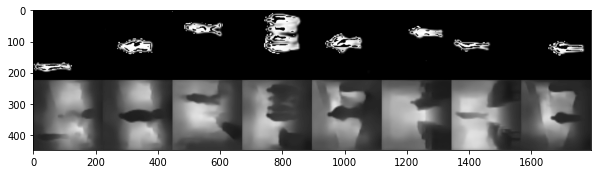

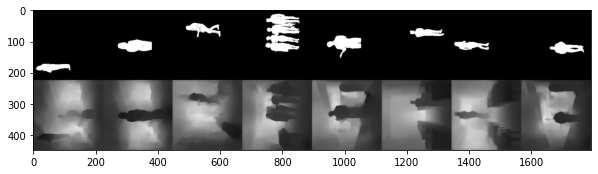

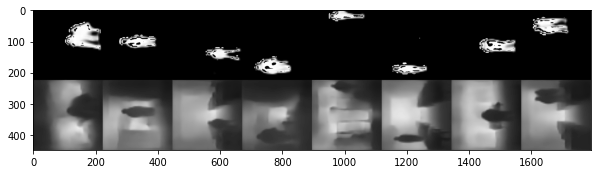

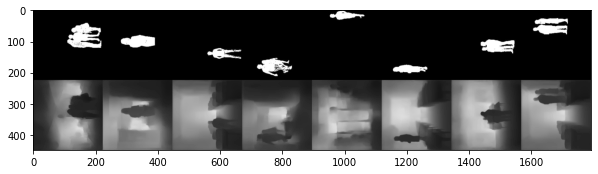

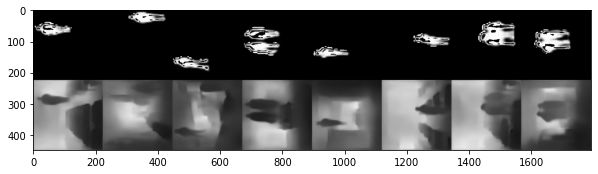

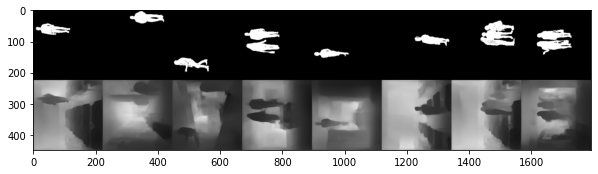

In [86]:
mmdtraintest.display_samples(expand_model, test_loader, device)

In [0]:
# PyTroch version
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    SMOOTH = 1e-6
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # Or thresholded.mean() if you are interested in average across the batch

In [107]:
output_pred[0][0],torch.sigmoid(output_pred[0][0])

(tensor([[[-1.5838e-05, -5.7901e-06,  4.2580e-06,  ...,  1.4038e-03,
            6.8209e-04, -3.9624e-05],
          [-1.9645e-05, -1.1782e-05, -3.9186e-06,  ...,  1.0586e-03,
            5.0723e-04, -4.4183e-05],
          [-2.3451e-05, -1.7773e-05, -1.2095e-05,  ...,  7.1348e-04,
            3.3237e-04, -4.8741e-05],
          ...,
          [ 9.2483e-05,  7.1347e-05,  5.0211e-05,  ..., -2.2080e-05,
           -3.7203e-05, -5.2327e-05],
          [ 1.1846e-04,  8.9445e-05,  6.0429e-05,  ..., -3.6948e-05,
           -6.4569e-05, -9.2190e-05],
          [ 1.4444e-04,  1.0754e-04,  7.0647e-05,  ..., -5.1816e-05,
           -9.1935e-05, -1.3205e-04]]]),
 tensor([[[0.5000, 0.5000, 0.5000,  ..., 0.5004, 0.5002, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5003, 0.5001, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5002, 0.5001, 0.5000],
          ...,
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.50

In [130]:
loss_func = [mmdlosses.LocalRMSELoss, mmdlosses.LocalSSIMLoss, mmdlosses.LocalPixelLoss, mmdlosses.LocalBCELoss, mmdlosses.dice_loss]
for loss_val in loss_func:    
    own_loss = loss_val(img['output'][0],img['output'][0])
    pred_loss = loss_val(output_pred[0],img['output'][0])
    print("Own loss:{} Pred Loss:{} Diff:{}".format(own_loss, pred_loss, torch.abs(pred_loss/own_loss)))
#mmdlosses.LocalRMSELoss(output_pred[0],img['output'][0])

Own loss:0.0 Pred Loss:0.10297174751758575 Diff:inf
Own loss:0.0 Pred Loss:0.0354447104036808 Diff:inf
Own loss:0.0 Pred Loss:0.004266039002686739 Diff:inf
Own loss:0.6770474314689636 Pred Loss:0.6846525073051453 Diff:1.0112327337265015
Own loss:0.8752159476280212 Pred Loss:0.8798667192459106 Diff:1.0053138732910156


In [125]:
mmdlosses.LocalRMSELoss(img['output'][0],img['output'][0])

tensor(0.)

In [101]:
iou_pytorch(output_pred[0], img['output'][0])

RuntimeError: ignored

In [0]:
del expand_model


In [91]:
for idx, img in enumerate(test_loader):
    if (idx > 3):
        break
    print("Loops")

Loops
Loops
Loops
Loops


In [100]:
output_pred[0].shape, img['output'][0].shape

(torch.Size([8, 1, 224, 224]), torch.Size([8, 1, 224, 224]))

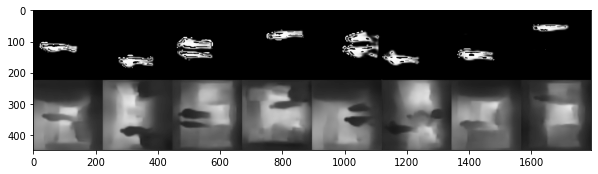

In [92]:
#img = iter(test_loader).next()
with torch.no_grad():
    output_val = expand_model(img['input'].to(device)).to("cpu")
output_pred = torch.split(output_val,1,dim=1)
# mask_pred = [kornia.tensor_to_image(((output_pred[0][val].to("cpu")*0.0016620444341229432+0.057950844077600344)*255).byte()) for val in range(8) ]
# depth_pred = [kornia.tensor_to_image(((output_pred[1][val].to("cpu")*0.03551773442719045+0.3679109312239146)*255).byte()) for val in range(8) ]

mask_pred = [kornia.tensor_to_image((output_pred[0][val].to("cpu")*255).byte()) for val in range(8) ]
depth_pred = [kornia.tensor_to_image((output_pred[1][val].to("cpu")*255).byte()) for val in range(8) ]


img_shape = img['output'][0][1].shape[1]
mask_gt = [img['output'][0][val].reshape(img_shape,img_shape) for val in range(8) ]
depth_gt = [img['output'][1][val].reshape(img_shape,img_shape) for val in range(8) ]
plt.figure(figsize=(10,10)) 
plt.imshow(np.vstack([np.hstack(mask_pred),np.hstack(depth_pred)]),cmap='gray')

In [53]:
mask_pred[0].shape

(224, 224)

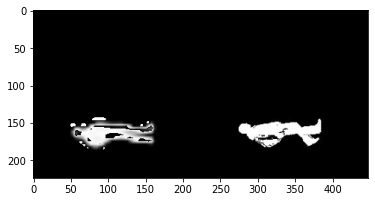

In [95]:
offset=1
plt.imshow(np.hstack([mask_pred[offset],mask_gt[offset]*255]), cmap='gray')

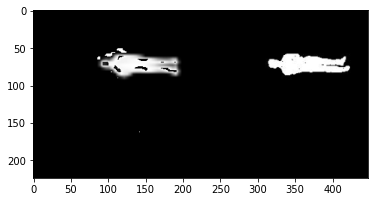

In [89]:
plt.imshow(np.hstack([mask_pred[offset],mask_gt[offset]*255]), cmap='gray')

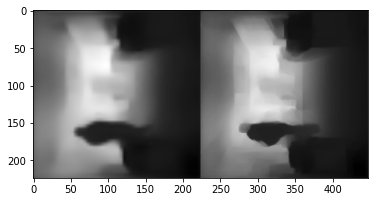

In [96]:
plt.imshow(np.hstack([depth_pred[offset],depth_gt[offset]*255]), cmap='gray')

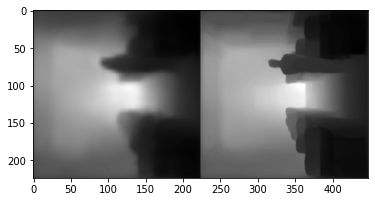

In [61]:
plt.imshow(np.hstack([depth_pred[offset],depth_gt[offset]*255]), cmap='gray')

In [0]:
torch.mean(mmdlosses.LocalL1Loss(img['output'][0][1], output_pred[0][1]))

tensor(12.1142)

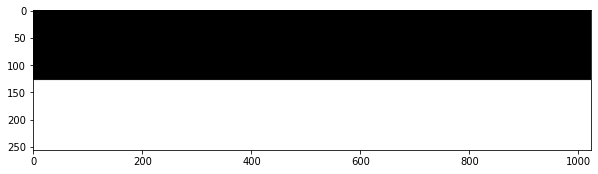

In [0]:
img = iter(train_loader).next()
with torch.no_grad():
    output_val = model_new(img['input'].to(device)).to("cpu")
output_pred = torch.split(output_val,1,dim=1)
# mask_pred = [kornia.tensor_to_image(((output_pred[0][val].to("cpu")*0.0016620444341229432+0.057950844077600344)*255).byte()) for val in range(8) ]
# depth_pred = [kornia.tensor_to_image(((output_pred[1][val].to("cpu")*0.03551773442719045+0.3679109312239146)*255).byte()) for val in range(8) ]

mask_pred = [kornia.tensor_to_image((output_pred[0][val].to("cpu")*255).byte()) for val in range(8) ]
depth_pred = [kornia.tensor_to_image((output_pred[1][val].to("cpu")*255).byte()) for val in range(8) ]


img_shape = img['output'][0][1].shape[1]
mask_gt = [img['output'][0][val].reshape(img_shape,img_shape) for val in range(8) ]
depth_gt = [img['output'][1][val].reshape(img_shape,img_shape) for val in range(8) ]
plt.figure(figsize=(10,10)) 
plt.imshow(np.vstack([np.hstack(mask_pred),np.hstack(depth_pred)]),cmap='gray')

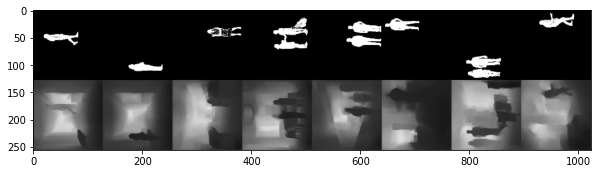

In [0]:
plt.figure(figsize=(10,10)) 
plt.imshow(np.vstack([np.hstack(mask_gt),np.hstack(depth_gt)]),cmap='gray')

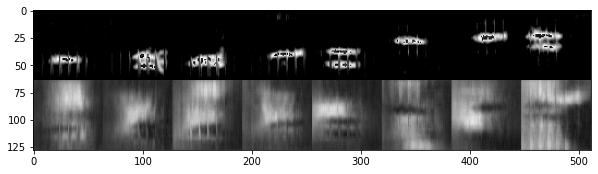

In [0]:
# plt.figure(figsize=(10,10)) 
plt.imshow(np.vstack([np.hstack(mask_pred),np.hstack(depth_pred)]),cmap='gray')

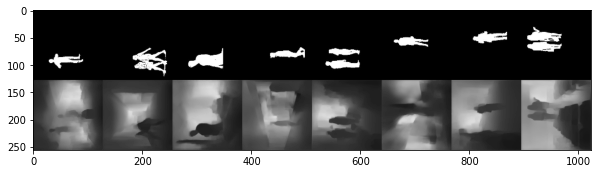

In [0]:
plt.figure(figsize=(10,10)) 
plt.imshow(np.vstack([np.hstack(mask_gt),np.hstack(depth_gt)]),cmap='gray')

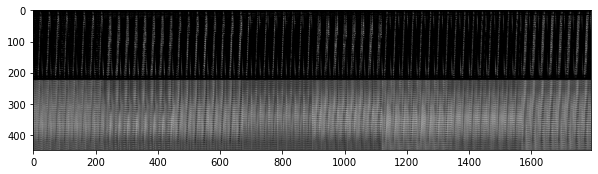

In [0]:
img = iter(train_loader_224).next()
with torch.no_grad():
    output_val = model_new(img['input'].to(device)).to("cpu")

output_pred = torch.split(output_val,1,dim=1)
mask_pred = [kornia.tensor_to_image((output_pred[0][val].to("cpu")*255).byte()) for val in range(8) ]
depth_pred = [kornia.tensor_to_image((output_pred[1][val].to("cpu")*255).byte()) for val in range(8) ]
mask_gt = [img['output'][0][val].reshape(224,224) for val in range(8) ]
depth_gt = [img['output'][1][val].reshape(224,224) for val in range(8) ]
plt.figure(figsize=(10,10)) 
plt.imshow(np.vstack([np.hstack(mask_pred),np.hstack(depth_pred)]),cmap='gray')


### bce_dice_with_rmse_ssim

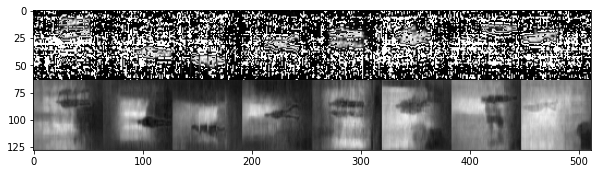

In [0]:
plt.figure(figsize=(10,10)) 
plt.imshow(np.vstack([np.hstack(mask_pred),np.hstack(depth_pred)]),cmap='gray')

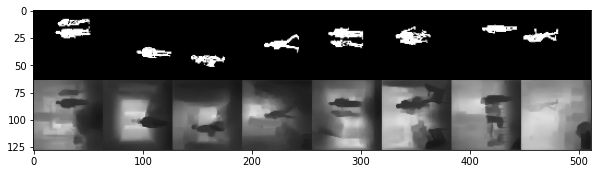

In [0]:
plt.figure(figsize=(10,10)) 
plt.imshow(np.vstack([np.hstack(mask_gt),np.hstack(depth_gt)]),cmap='gray')

In [0]:
plt.imshow(np.hstack([img['output'][1][offset].reshape(64,64),   depth_pred[offset]]),cmap='gray')

## bce_with_rmse

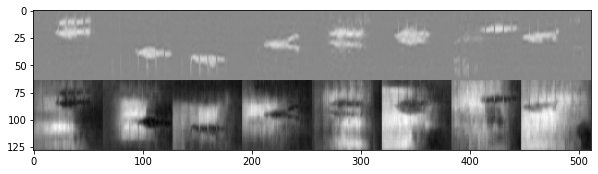

In [0]:
plt.figure(figsize=(10,10)) 
plt.imshow(np.vstack([np.hstack(mask_pred),np.hstack(depth_pred)]),cmap='gray')

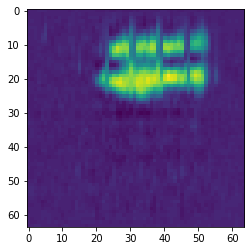

In [0]:
plt.imshow(mask_pred[0])

In [0]:
dice_loss(img['output'][0], output_pred[0])

tensor(0.8533)

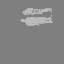

In [0]:
Image.fromarray(kornia.tensor_to_image(((torch.sigmoid(img['output'][0])*255).byte()[0])))

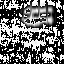

In [0]:
Image.fromarray(kornia.tensor_to_image(((output_pred[0]*255).byte()[0])))

In [0]:
Image.fromarray(kornia.tensor_to_image(((torch.sigmoid(output_pred[0])*255).byte()[0])))

In [0]:
kornia.losses.dice_loss((img['output'][0]*255), (output_pred[0]*255))

In [0]:
output_pred[0].shape

torch.Size([64, 1, 64, 64])

In [0]:
dice_loss(img['output'][0][0], output_pred[0][0])

tensor(0.8170)

In [0]:
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.
    
    iflat = input.view(-1)
    tflat = target.contiguous().view(-1)#reshape(64*64*64)
    #target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return 1 - ((2. * intersection + smooth) /
              (iflat.sum() + tflat.sum() + smooth))

In [0]:
nn.BCEWithLogitsLoss()(img['output'][0], output_pred[0])

tensor(0.6849)

In [0]:
len(mask_pred)

8

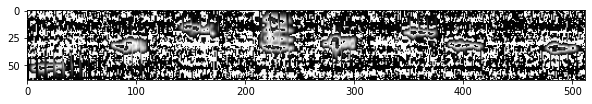

In [0]:
#Image.fromarray(kornia.tensor_to_image((mask_pred*255).byte())),
plt.figure(figsize=(10,10)) 
plt.imshow(np.hstack(mask_pred),cmap='gray')

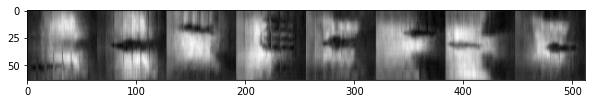

In [0]:
#Image.fromarray(kornia.tensor_to_image((mask_pred*255).byte())),
plt.figure(figsize=(10,10)) 
plt.imshow(np.hstack(depth_pred),cmap='gray')#

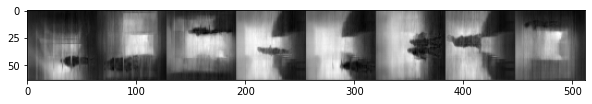

In [0]:


Image.fromarray(kornia.tensor_to_image((mask_pred*255).byte())),
plt.figure(figsize=(10,10)) 
plt.imshow(np.hstack(depth_pred),cmap='gray')#

In [0]:
!pip install kornia

     |████████████████████████████████| 163kB 6.0MB/s 


In [0]:
for zip(img['input'][0],img['input'][1])

In [0]:
np.concatenate((img['input'][0][0].numpy(),img['input'][0][1].numpy()), axis=2).shape

(250, 250, 6)

In [0]:
 
pbar = tqdm(depth_dataset)

#bg_mean = np.zeros((4,3))
n, mean, M2 = (0.0,0.0,0.0)
for i_batch,img in enumerate(pbar):
    #img = depth_dataset[i_batch]
    #img_mean = np.mean(img, axis=(0,1))
    img_mean = np.array([ np.mean(iter_val/255.0,axis=(0,1)) for left_k,right_v in img.items() for iter_val in right_v ])
    n, mean, M2 = update_mean_variance((n, mean, M2), img_mean)

print(finalize_mean_variance(n, mean, M2))

In [0]:
# hf = h5py.File('data7.h5', 'w')
# #base_zip = ZipFile('/content/image_mask_gt2k6k.zip')
# #pbar = tqdm(depth_dataset)
# #hf.close()
# def hf_create_dataset(hdf_file, file_name, data):
#     hdf_file.create_dataset(
#                 name=file_name,
#                 data=data,
#                 compression="gzip", compression_opts=9
#                 )
# i_batch=0
# #for i_batch,img in enumerate(pbar):
# start = time.process_time()
# #try:
# for img in depth_dataset:
#     #key_name = 
#     if(i_batch > 100000):
#         break
#     #val_arr = [iter_val 
#     for left_k,right_v in img.items():
#         for inner_k, iter_val in right_v.items():
#             #print(inner_k)
#             hf_create_dataset(hf, inner_k ,iter_val)

#     if(i_batch % 1000 == 0 and i_batch > 1000):
#         current = time.process_time()
#         print("No:of records processed:{} Time Elapsed:{}".format(i_batch, current-start))
#     i_batch += 1

# end = time.process_time()
# print("No:of records processed:{} Time Elapsed:{}".format(i_batch, end-start))
# #except:

# #    hf.close()

In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:
from googleapiclient.discovery import build
gcs_service = build('storage', 'v1')

In [0]:
import uuid
bucket_name = 'colab-sample-bucket-' + str(uuid.uuid1())

body = {
  'name': bucket_name,
  # For a full list of locations, see:
  # https://cloud.google.com/storage/docs/bucket-locations
  'location': 'us',
}
gcs_service.buckets().insert(project=project_id, body=body).execute()
print('Done')

In [0]:
hf.close()

In [0]:
hf_read = h5py.File('data7.h5', 'r')

In [0]:
hf_read.keys()

<KeysViewHDF5 ['depth_image_023aa22186_classroom_1.jpg', 'depth_image_0ccf0b6adb_classroom_8.jpg', 'depth_image_0d06379c4e_classroom_12.jpg', 'depth_image_100078863e_classroom_10.jpg', 'depth_image_1000d68e48_classroom_2.jpg', 'depth_image_10023ed777_classroom_12.jpg', 'depth_image_10027aa3fa_classroom_4.jpg', 'depth_image_1002953763_classroom_1.jpg', 'depth_image_1002a448f4_classroom_10.jpg', 'depth_image_1002be3508_classroom_3.jpg', 'depth_image_1002e52563_classroom_14.jpg', 'depth_image_1002e75f62_classroom_15.jpg', 'depth_image_100317e99d_classroom_14.jpg', 'depth_image_1003212d72_classroom_8.jpg', 'depth_image_10033c4a69_classroom_8.jpg', 'depth_image_10038181d7_classroom_3.jpg', 'depth_image_1003ffcca2_classroom_10.jpg', 'depth_image_1004993b2d_classroom_13.jpg', 'depth_image_1004dd5dd3_classroom_16.jpg', 'depth_image_100659c8dd_classroom_17.jpg', 'depth_image_1006609a43_classroom_16.jpg', 'depth_image_10074a3520_classroom_8.jpg', 'depth_image_1007f75489_classroom_8.jpg', 'depth_

In [0]:
### Knuth/Welford algorithm to generate mean by addition of new samples to existing mean

def update_mean_variance(existingAggregate, newValue):
    (count, mean, M2) = existingAggregate
    count += 1
    delta = newValue - mean
    mean += delta / count
    delta2 = newValue - mean
    M2 += delta * delta2

    return (count, mean, M2)

# Retrieve the mean, variance and sample variance from an aggregate
def finalize_mean_variance(existingAggregate):
    (count, mean, M2) = existingAggregate
    if count < 2:
        return float('nan')
    else:
       (mean, variance, sampleVariance) = (mean, M2 / count, M2 / (count - 1))
       return (mean, variance, sampleVariance)

In [0]:
calc_mean,variance, _ = finalize_mean_variance((n, mean, M2))
print(calc_mean)
print(np.sqrt(variance))

[[0.56632738 0.51567622 0.45670792]
 [0.57469445 0.52241555 0.45992244]
 [0.05795104 0.05795104 0.05795104]
 [0.61635181 0.21432114 0.50569604]]
[[0.1076622  0.10650349 0.12808967]
 [0.11322354 0.11195428 0.13441683]
 [0.02640032 0.02640032 0.02640032]
 [0.09193359 0.07619106 0.04919082]]


In [0]:
#depth_map = np.hstack([depth_dataset[index_val]['output'][1] for index_val in myrandom_array])
depth_map = [depth_dataset[index_val]['output'][1] for index_val in myrandom_array]
mask_image = [depth_dataset[index_val]['output'][0] for index_val in myrandom_array]
bg_image = [depth_dataset[index_val]['input'][1] for index_val in myrandom_array]
fg_bg_image = [depth_dataset[index_val]['input'][0] for index_val in myrandom_array]
final_list = np.hstack([ mask_image, bg_image, fg_bg_image])

In [0]:
from matplotlib import pyplot as plt

In [0]:
plt.figure(figsize=(24,32))
plt.imshow(depth_map,cmap='gray')

In [0]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

fig = plt.figure(figsize=(100., 100.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 20),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
for ax, im in zip(grid, depth_map):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()

In [0]:
plt.savefig('/content/drive/My Drive/EVA4/tsai/S15EVA4/depthmaptile.png')

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

fig = plt.figure(figsize=(100., 100.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 20),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
for ax, im in zip(grid, final_list):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()

In [0]:
Image.fromarray(depth_dataset[0]['output'][0])

In [0]:
Image.fromarray(depth_dataset[0]['output'][1])

In [0]:
import glob
fileList = [file_name for file_name in glob.glob('/content/drive/My Drive/EVA4/tsai/S15EVA4/people_cropresize/*png')]
print("Number of images of people:{}".format(len(fileList)))

Number of images of people:110


In [0]:
import os

for file_name in fileList:
    image_name = os.path.basename(file_name)
    my_array = np.array(Image.open(file_name))
    print("FileName: {} Shape:{}".format(image_name, my_array.shape))

In [0]:
base_dir = '/content/drive/My Drive/EVA4/tsai/S15EVA4/people_cropresize/'
aug_path = '/content/drive/My Drive/EVA4/tsai/S15EVA4/people_cropresize/aug_images'
image_list = [ ]


for file_name in glob.glob(base_dir+"/*png")[:20]:
    basefile_name = os.path.basename(file_name)
    #print(basefile_name)
    mask_name = os.path.join(aug_path,"mask_"+basefile_name)
    flip_name = os.path.join(aug_path,"flip_"+basefile_name)
    flip_mask_name = os.path.join(aug_path,"mask_"+os.path.basename(flip_name))
    print(file_name,mask_name,flip_name,  flip_mask_name)
    image_list.append([np.array(Image.open(val)) for val in [file_name,mask_name,flip_name,  flip_mask_name ]])

In [0]:
for val in image_list:
    plt.imshow(np.hstack([val[0],val[2]]))
    plt.imshow(np.hstack([val[1],val[3]]))

In [0]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
#for iter in image_list:
for ax, im in zip(grid, image_list[2]):
    #print(ax., )
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap='gray')

In [0]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

In [0]:
model = ResNet50(weights='imagenet')

102973440/102967424 [==============================] - 1s 0us/step


In [0]:
model.summary()

In [0]:
#csv_file = '/content/drive/My Drive/EVA4/tsai/S15EVA4/DepthMapDataSetSample.csv'
batch_start = 90000
batch_end = batch_start+30000

test_batch_start = 512
test_batch_end = test_batch_start + 1512
csv_file ='/content/drive/My Drive/EVA4/tsai/S15EVA4/FinalDataSet/DepthMapDataSetTrain.csv'
root_dir = '/content/drive/My Drive/EVA4/tsai/S15EVA4/'
size_hw = (128,128)
depth_dataset = mmddataloader.DepthMaskDataSet(csv_file, root_dir, batch_start,batch_end, read_zip=True,
                                 transform_base=mmddataloader.resize_bg(size_hw[0],size_hw[1],[0.56632738, 0.51567622, 0.45670792], [0.1076622, 0.10650349, 0.12808967] ),
                                 transform_bg=mmddataloader.resize_bg(size_hw[0],size_hw[1],[0.57469445, 0.52241555, 0.45992244], [0.11322354, 0.11195428, 0.13441683]),
                                  transform_mask = mmddataloader.resize_bg_nonNorm(size_hw[0],size_hw[1]),
                                  transform_depth = mmddataloader.resize_bg_nonNorm(size_hw[0],size_hw[1]),
                                 #transform_mask=mmddataloader.resize_bg(size_hw[0],size_hw[1], [0.0579508], [0.001662]),
                                 #transform_depth=mmddataloader.resize_bg(size_hw[0],size_hw[1], [0.3679109], [0.03551773]),
                                 )
from torch.utils.data import DataLoader
kwargs= { 'num_workers':1,'pin_memory': True}
train_loader = DataLoader(depth_dataset, batch_size=64, shuffle=False, **kwargs)

test_dataset = mmddataloader.DepthMaskDataSet(csv_file, root_dir, test_batch_start,test_batch_end,read_zip=True,
                                 transform_base=mmddataloader.resize_bg(size_hw[0],size_hw[1],[0.56632738, 0.51567622, 0.45670792], [0.1076622, 0.10650349, 0.12808967] ),
                                 transform_bg=mmddataloader.resize_bg(size_hw[0],size_hw[1],[0.57469445, 0.52241555, 0.45992244], [0.11322354, 0.11195428, 0.13441683]),
                                 transform_mask = mmddataloader.resize_bg_nonNorm(size_hw[0],size_hw[1]),
                                 transform_depth = mmddataloader.resize_bg_nonNorm(size_hw[0],size_hw[1]),
                                 #transform_mask=mmddataloader.resize_bg(size_hw[0],size_hw[1], [0.0579508], [0.001662]),
                                 #transform_depth=mmddataloader.resize_bg(size_hw[0],size_hw[1], [0.3679109], [0.03551773]),
                                 )
from torch.utils.data import DataLoader
kwargs= { 'num_workers':1,'pin_memory': True}
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, **kwargs)